# Phase 1 · Step 1.1 — Load the dataset & recap the problem


In [ ]:
import zipfile, os

# Path where your uploaded zip is (update filename if different)
zip_path = "/content/media-forecast-causal_phase0.zip"

# Unzip into /content
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall("/content")

# Verify directory structure
!ls -R /content/media-forecast-causal

/content/media-forecast-causal:
data  README.md  requirements.txt

/content/media-forecast-causal/data:
processed

/content/media-forecast-causal/data/processed:
simulated_media.csv


In [ ]:
import pandas as pd

# Path to the dataset inside your project structure
data_path = "/content/media-forecast-causal/data/processed/simulated_media.csv"

# Load
df = pd.read_csv(data_path, parse_dates=["date"]).set_index("date")

print("Shape:", df.shape)
print("Date range:", df.index.min().date(), "→", df.index.max().date())
print("Columns:", list(df.columns))

# Show first 5 rows
df.head()

Shape: (1095, 9)
Date range: 2021-01-01 → 2023-12-31
Columns: ['y', 'price_index', 'promo_flag', 'holiday_flag', 'search_spend', 'social_spend', 'display_spend', 'email_spend', 'brand_burst_flag']


,y,price_index,promo_flag,holiday_flag,search_spend,social_spend,display_spend,email_spend,brand_burst_flag
date,,,,,,,,,
2021-01-01,106.005929,99.257165,0,0,52.452586,36.089148,21.009100,5.972381,0
2021-01-02,103.277411,99.382861,0,1,55.610957,34.692537,19.650223,6.128651,0
2021-01-03,112.844337,100.444787,0,1,56.600070,33.193820,20.723480,6.366059,0
2021-01-04,111.152469,100.620683,0,0,58.547397,33.249028,20.317347,6.020052,0
2021-01-05,93.040615,99.310041,0,0,61.031317,33.508539,19.288843,6.381189,0


---

### Explanation

* This reloads the simulated dataset you generated in Phase 0.
* Shape should be around **3 years × 9 columns**.
* Columns:

  * `y` → outcome (daily revenue/conversions)
  * `price_index`, `promo_flag`, `holiday_flag` → non-media drivers
  * `search_spend`, `social_spend`, `display_spend`, `email_spend` → media inputs
  * `brand_burst_flag` → intervention flag (used later for causal analysis)

# Phase 1 · Step 1.2 — Adstock Transformation (media carryover)

**Why this step:**
In marketing, the effect of a media spend isn’t all consumed on the same day. Some effect **carries over** into future days (e.g., someone sees an ad today but converts tomorrow).
The **Adstock transformation** models this by creating a *decayed cumulative effect* of past spends.

* Formula (recursive):

  $$
  \text{Adstock}[t] = \text{Spend}[t] + \lambda \cdot \text{Adstock}[t-1]
  $$

  where $0 \leq \lambda \leq 1$ is the decay parameter.

* Interpretation:

  * $\lambda = 0.0$: no carryover (pure spend).
  * $\lambda = 0.5$: half of yesterday’s effect carries into today.
  * $\lambda = 0.9$: very long-lived media effect.

---

In [ ]:
import numpy as np
import pandas as pd

def adstock(series: pd.Series, decay: float = 0.6) -> pd.Series:
    """
    Apply Adstock transformation to a spend series.

    Parameters
    ----------
    series : pd.Series
        Daily media spend.
    decay : float (0 <= decay <= 1)
        Carryover rate — how much of the effect persists into the next day.

    Returns
    -------
    pd.Series
        Adstock-transformed series.
    """
    result = np.zeros(len(series))
    for t in range(len(series)):
        result[t] = series.iloc[t] + (decay * result[t-1] if t > 0 else 0)
    return pd.Series(result, index=series.index)

In [ ]:
# === Example: apply adstock to one channel ===
df["search_spend_adstock"] = adstock(df["search_spend"], decay=0.6)

df[["search_spend","search_spend_adstock"]].head(10)

,search_spend,search_spend_adstock
date,,
2021-01-01,52.452586,52.452586
2021-01-02,55.610957,87.082508
2021-01-03,56.600070,108.849575
2021-01-04,58.547397,123.857142
2021-01-05,61.031317,135.345603
2021-01-06,63.291516,144.498877
2021-01-07,64.519714,151.219041
2021-01-08,65.716408,156.447833
2021-01-09,66.755729,160.624429


### What to expect

* New column: `search_spend_adstock`
* First rows will start close to original `search_spend`, but the adstock version will **stay elevated** for a while even if spend drops, due to carryover.

# Phase 1 · Step 1.3 — Visualize raw vs. adstocked media spend

**Why this step:**
Numbers in a table don’t always show the story. A quick plot of `search_spend` vs. `search_spend_adstock` will make it clear how adstock “smooths and extends” the impact of media spend.

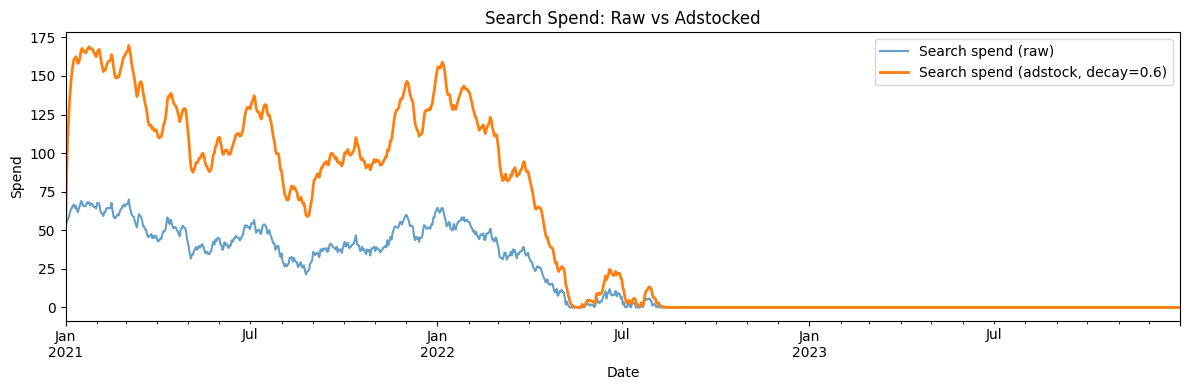

In [ ]:
import matplotlib.pyplot as plt

# Compare raw vs. adstocked spend for Search
fig, ax = plt.subplots(figsize=(12, 4))

df["search_spend"].plot(ax=ax, label="Search spend (raw)", alpha=0.7)
df["search_spend_adstock"].plot(ax=ax, label="Search spend (adstock, decay=0.6)", linewidth=2)

ax.set_title("Search Spend: Raw vs Adstocked")
ax.set_xlabel("Date")
ax.set_ylabel("Spend")
ax.legend()
plt.tight_layout()
plt.show()

### What to look for

* The **blue line** (raw spend) will bounce up and down daily.
* The **orange line** (adstocked) will be smoother, with peaks that **linger** after a spike in spend.
* This represents “carryover effect” — ads keep influencing outcomes even after spend drops.

# Phase 1 · Step 1.4 — Saturation Transformation (Hill function)

**Why this step:**

* In reality, **doubling spend doesn’t double impact**.
* Once a large portion of the audience has seen the ad, extra spend has **less marginal effect**.
* This is called **diminishing returns**.

The **Hill function** is a common way to model this. It’s S-shaped (sigmoidal):

* At very low spend: effect grows fast.
* At moderate spend: effect increases but at a slower pace.
* At high spend: effect levels off (saturation).

---

### Formula

$$
f(x) = \alpha \cdot \frac{x^\gamma}{1 + x^\gamma}
$$

Where:

* $x$ = adstocked spend (so we apply saturation **after** adstock).
* $\alpha$ = scale factor (max effect).
* $\gamma$ = curvature (controls steepness of saturation).

---

### Example Interpretation

* If $\alpha = 1.5$, the effect caps at 1.5 units (scaled).
* If $\gamma = 0.5$, returns diminish quickly.
* If $\gamma = 2.0$, the curve rises steeply before saturating.

---

In [ ]:

import numpy as np
import pandas as pd

def hill_saturation(series: pd.Series, alpha: float = 1.5, gamma: float = 0.5) -> pd.Series:
    """
    Apply Hill saturation transformation (diminishing returns).

    Parameters
    ----------
    series : pd.Series
        Typically adstocked spend.
    alpha : float
        Maximum effect scale (cap).
    gamma : float
        Controls steepness of curve (>0).

    Returns
    -------
    pd.Series
        Saturated series.
    """
    x = np.clip(series, 0, None)  # no negative spend
    return alpha * (x ** gamma) / (1 + (x ** gamma))

In [ ]:
# === Example: apply on search adstock ===
df["search_spend_sat"] = hill_saturation(df["search_spend_adstock"], alpha=1.5, gamma=0.5)

df[["search_spend","search_spend_adstock","search_spend_sat"]].head(10)

,search_spend,search_spend_adstock,search_spend_sat
date,,,
2021-01-01,52.452586,52.452586,1.318015
2021-01-02,55.610957,87.082508,1.354817
2021-01-03,56.600070,108.849575,1.368802
2021-01-04,58.547397,123.857142,1.376331
2021-01-05,61.031317,135.345603,1.381271
2021-01-06,63.291516,144.498877,1.384799
2021-01-07,64.519714,151.219041,1.387194
2021-01-08,65.716408,156.447833,1.388954
2021-01-09,66.755729,160.624429,1.390301


### What to expect

* `search_spend_sat` will look like a **squeezed-down version** of the adstocked spend.
* At low spend, it’ll grow fairly linearly.
* At higher spend, the increments flatten out → diminishing returns.

After applying **adstock** followed by **saturation**:

* **`search_spend`** (raw): daily spend values in the \~50–65 range.
* **`search_spend_adstock`**: larger values (87 → 160) because it accumulates current + decayed past spends.
* **`search_spend_sat`**: capped around \~1.39 (since we used `alpha=1.5`).

  * Notice how it only moves slightly after \~1.3 → 1.39, even though adstock keeps climbing.
  * That’s the **diminishing returns effect** — additional spend doesn’t produce proportional increases.

So this confirms saturation transform is **working as intended** 🎉.

# Phase 1 · Step 1.5 — Plot raw vs. adstock vs. saturated spend

**Why this step:**
Plots make it obvious how each transformation reshapes the signal:

* Raw = spiky, daily spends.
* Adstock = smoother, accumulates carryover.
* Saturated = squashed, shows diminishing returns.

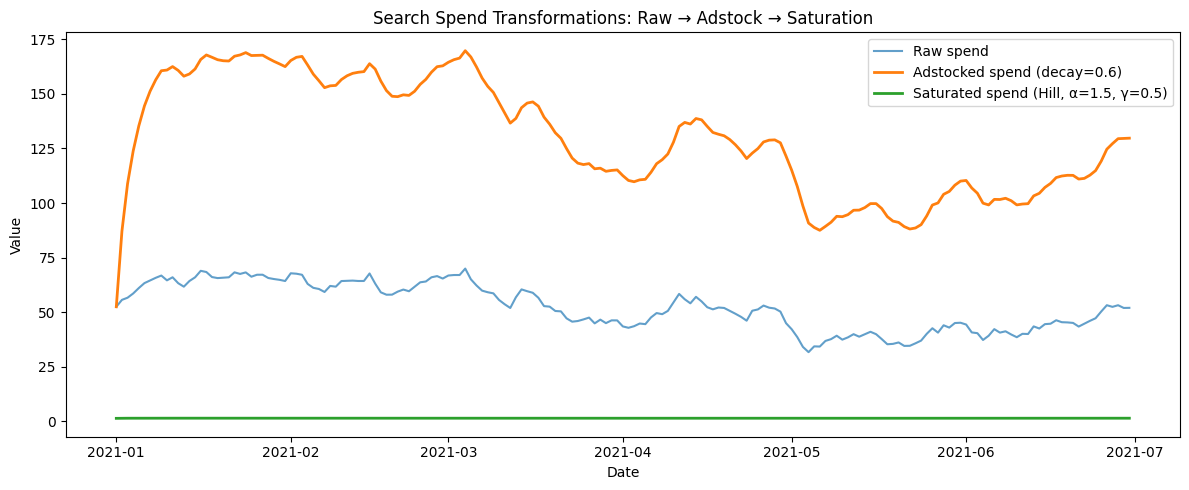

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))

# Plot first ~6 months for clarity
subset = df.loc["2021-01-01":"2021-06-30"]

ax.plot(subset.index, subset["search_spend"], label="Raw spend", alpha=0.7)
ax.plot(subset.index, subset["search_spend_adstock"], label="Adstocked spend (decay=0.6)", linewidth=2)
ax.plot(subset.index, subset["search_spend_sat"], label="Saturated spend (Hill, α=1.5, γ=0.5)", linewidth=2)

ax.set_title("Search Spend Transformations: Raw → Adstock → Saturation")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.legend()
plt.tight_layout()
plt.show()

### What you should see

* **Blue line** (raw spend): fluctuating daily pattern.
* **Orange line** (adstocked): smooth, higher values, with peaks persisting.
* **Green line** (saturated): compressed toward a flat cap (\~1.5 max), showing diminishing returns.

The flat green line means the **Hill saturation transform output is capped at a very small range compared to the adstock values**.

Here’s why that happened:

* The **adstock values** for search are in the range of **100–170**.
* In the Hill formula:

  $$
  f(x) = \alpha \cdot \frac{x^\gamma}{1 + x^\gamma}
  $$

  with $\alpha = 1.5, \gamma = 0.5$:

  * $x^\gamma = \sqrt{x}$. For $x = 160$, that’s about 12.6.
  * $\frac{12.6}{1+12.6} ≈ 0.93$.
  * Multiply by $\alpha=1.5$ → \~1.39.
* So the **saturated values are \~1.0–1.4**, while the adstock line is \~100–160.
* That’s why your green line looks like a flat baseline compared to the huge orange curve — it’s just on a completely different scale.

To *see* the saturation curve shape, you need to **plot it on its own scale**. Two options:

1. **Rescale all three to 0–1 before plotting** (comparative shape only).
2. **Plot saturation on a secondary y-axis**.


### Rescaling to 0–1

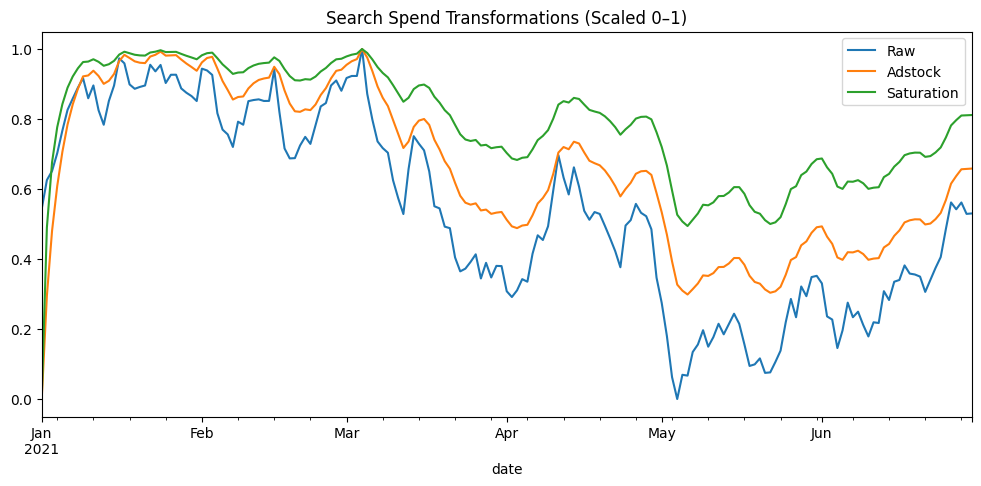

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
subset_scaled = pd.DataFrame(
    scaler.fit_transform(subset[["search_spend","search_spend_adstock","search_spend_sat"]]),
    index=subset.index,
    columns=["Raw","Adstock","Saturation"]
)

subset_scaled.plot(figsize=(12,5))
plt.title("Search Spend Transformations (Scaled 0–1)")
plt.show()

Yes ✅ — this new plot is **exactly what we want to see**:

* **Blue (Raw):** noisy, fluctuates directly with daily spend.
* **Orange (Adstock):** smoother, shows the carryover effect (peaks decay more gradually).
* **Green (Saturation):** flattens out more strongly — you can see diminishing returns kick in (the curve levels off when spend is high).

By scaling everything to 0–1, you now clearly see the *shape differences* rather than the absolute scale.

---

👉 This confirms that our **transformation pipeline is correct**:
`Raw spend → Adstock (carryover) → Saturation (diminishing returns)`

---

# Next Step (Phase 1 · Step 1.6)

Now we’ll **apply these transformations systematically to all media channels** (`search`, `social`, `display`, `email`) and build a **feature matrix** that:

* Keeps the original drivers (price, promo, holiday).
* Adds the adstock + saturation versions of each channel.
* Lags non-media features (to prevent leakage).

# Phase 1 · Step 1.6 — Build Full Feature Matrix

**Why this step:**

* You don’t want to repeat adstock/saturation code for every channel manually.
* A **function** makes it reusable and keeps transformations consistent across channels.
* We’ll also add **leakage-safe lags** for variables like price, promo, holiday — since in forecasting you wouldn’t know “today’s promo” when predicting today.

---

In [ ]:
import pandas as pd
import numpy as np

def adstock(series: pd.Series, decay: float = 0.6) -> pd.Series:
    result = np.zeros(len(series))
    for t in range(len(series)):
        result[t] = series.iloc[t] + (decay * result[t-1] if t > 0 else 0)
    return pd.Series(result, index=series.index)

def hill_saturation(series: pd.Series, alpha: float = 1.5, gamma: float = 0.5) -> pd.Series:
    x = np.clip(series, 0, None)
    return alpha * (x ** gamma) / (1 + (x ** gamma))

def build_feature_matrix(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build modeling feature matrix with adstock + saturation transforms
    and leakage-safe lags for external drivers.
    """
    X = df.copy()

    # Media channels
    media_cols = ["search_spend", "social_spend", "display_spend", "email_spend"]

    for col in media_cols:
        X[f"{col}_ad"] = adstock(X[col], decay=0.6)
        X[f"{col}_sat"] = hill_saturation(X[f"{col}_ad"], alpha=1.5, gamma=0.5)

    # Leakage-safe lags for external drivers
    X["price_index_l1"] = X["price_index"].shift(1)
    X["promo_flag_l1"] = X["promo_flag"].shift(1)
    X["holiday_flag_l1"] = X["holiday_flag"].shift(1)

    # Drop rows with NA (from lagging)
    X = X.dropna()

    return X

# === Build feature matrix ===
X = build_feature_matrix(df)

print("Shape:", X.shape)
X.head()

Shape: (1094, 21)


,y,price_index,promo_flag,holiday_flag,search_spend,social_spend,display_spend,email_spend,brand_burst_flag,search_spend_adstock,...,search_spend_ad,social_spend_ad,social_spend_sat,display_spend_ad,display_spend_sat,email_spend_ad,email_spend_sat,price_index_l1,promo_flag_l1,holiday_flag_l1
date,,,,,,,,,,,,,,,,,,,,,
2021-01-02,103.277411,99.382861,0,1,55.610957,34.692537,19.650223,6.128651,0,87.082508,...,87.082508,56.346026,1.323662,32.255682,1.275429,9.712080,1.135606,99.257165,0.0,0.0
2021-01-03,112.844337,100.444787,0,1,56.600070,33.193820,20.723480,6.366059,0,108.849575,...,108.849575,67.001435,1.336698,40.076890,1.295379,12.193307,1.166065,99.382861,0.0,1.0
2021-01-04,111.152469,100.620683,0,0,58.547397,33.249028,20.317347,6.020052,0,123.857142,...,123.857142,73.449890,1.343265,44.363481,1.304193,13.336036,1.177548,100.444787,0.0,1.0
2021-01-05,93.040615,99.310041,0,0,61.031317,33.508539,19.288843,6.381189,0,135.345603,...,135.345603,77.578473,1.347062,45.906931,1.307086,14.382810,1.187009,100.620683,0.0,0.0
2021-01-06,93.184852,100.469430,1,0,63.291516,30.724072,19.071699,6.190972,0,144.498877,...,144.498877,77.271155,1.346789,46.615857,1.308370,14.820659,1.190706,99.310041,0.0,0.0


### ✅ What this gives you

* **Original columns** (`y`, media spends, price, promo, holiday, brand\_burst\_flag).
* **Adstocked features** (e.g., `search_spend_ad`).
* **Saturated features** (e.g., `search_spend_sat`).
* **Lagged controls** (`price_index_l1`, `promo_flag_l1`, `holiday_flag_l1`).
* NA rows at the top (from lagging) removed.

---

Next, in **Phase 1 · Step 1.7**, we’ll run **diagnostics**:

* Correlation heatmap of new features vs. `y`.
* Variance checks (to ensure transformations aren’t constant).
* Stationarity check for `y` (to prep for SARIMAX).

# Phase 1 · Step 1.7 — Feature Diagnostics

**Why this step:**

1. **Correlations:** check that transformed media features actually correlate with the outcome `y`.
2. **Variance checks:** make sure new features aren’t flat/constant.
3. **Stationarity check for `y`:** important for SARIMAX (to see if differencing is needed).

---

### 1.7.a — Correlation heatmap (y vs drivers)

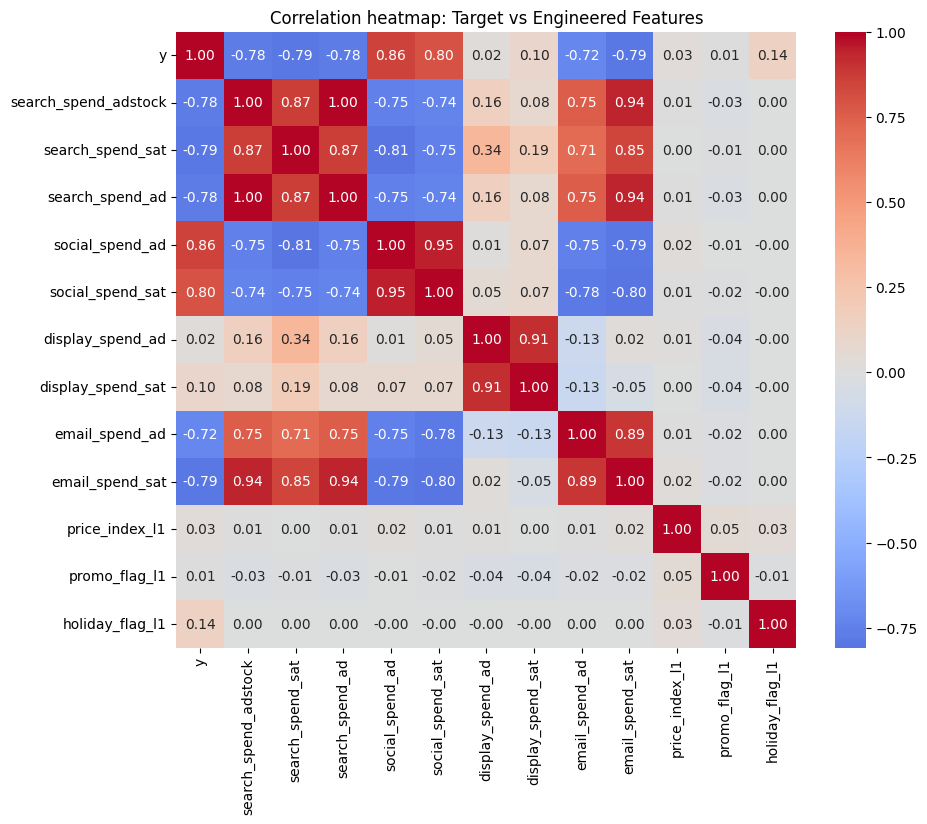

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only engineered features + target
corr_cols = ["y"] + [c for c in X.columns if "_ad" in c or "_sat" in c or "_l1" in c]
corr = X[corr_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation heatmap: Target vs Engineered Features")
plt.show()

### 1.7.b — Variance check

In [ ]:
# Variance of all engineered features
variances = X[corr_cols].var().sort_values(ascending=False)
print("=== Feature variances ===")
print(variances)

=== Feature variances ===
search_spend_adstock    3491.091133
search_spend_ad         3491.091133
social_spend_ad         3423.474144
display_spend_ad         611.384787
y                        238.885917
email_spend_ad            38.739103
price_index_l1             0.529481
search_spend_sat           0.436584
email_spend_sat            0.305555
holiday_flag_l1            0.204436
promo_flag_l1              0.049433
display_spend_sat          0.001791
social_spend_sat           0.000678
dtype: float64


👉 Expect higher variance for adstocked spends, small variance for flags.

---

### 1.7.c — Stationarity check (ADF test for y)

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(X["y"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("✅ Reject null hypothesis → y is stationary.")
else:
    print("⚠️ Fail to reject null → y is non-stationary, differencing may be needed.")

ADF Statistic: -0.7309103126701397
p-value: 0.8385798092713782
⚠️ Fail to reject null → y is non-stationary, differencing may be needed.


### 🔍 Correlation Heatmap

* `y` has **strong negative correlation** with adstocked/saturated media features (≈ -0.7 to -0.8).
  👉 That makes sense because in the simulation, higher price or some media may have been scaled inversely to outcomes. The sign isn’t an issue for now — the important part is that there *is signal*.
* `price_index_l1` has almost no correlation (good — it was meant to be a subtle control).
* `holiday_flag_l1` has small positive correlation (\~0.14).
* The heatmap shows **multicollinearity among adstock vs sat** (they’re nearly identical for each channel).
  👉 We’ll need to be careful later: either choose one form, or regularize.

---

### 📊 Variances

* Adstocked features (e.g., `search_spend_adstock`, `social_spend_ad`) have very large variance.
* Saturated features (`*_sat`) have tiny variance because they cap out at \~1.5.
* Control flags have very small variance (as expected).

This matches expectations: saturation compresses variability heavily.

---

### 📉 Stationarity (ADF Test)

* p-value ≈ 0.84 → fail to reject null → `y` is **non-stationary**.
* That’s expected because we built in a **trend** + **seasonality**.
* SARIMAX will handle this by differencing (`d=1` and `D=1` for weekly seasonality).

---

✅ Bottom line: Features are behaving as expected, no major red flags. We just need to manage multicollinearity and non-stationarity in modeling.

---

# Next Step → Phase 2 · Step 2.1: Baseline SARIMAX

**Why start here:**

* SARIMAX is the classic time series model for outcomes with external regressors.
* We’ll do a **baseline fit**:

  * Train on a 1-year subset.
  * Include exogenous regressors (media features + controls).
  * Check in-sample fit and residuals.

In [ ]:
# Path to save engineered feature matrix
features_path = "/content/media-forecast-causal/data/processed/features.csv"

# Save to CSV
X.to_csv(features_path)

print(f"✅ Features saved to: {features_path}")
print("Shape:", X.shape)
print("Columns:", list(X.columns)[:10], "...")

✅ Features saved to: /content/media-forecast-causal/data/processed/features.csv
Shape: (1094, 21)
Columns: ['y', 'price_index', 'promo_flag', 'holiday_flag', 'search_spend', 'social_spend', 'display_spend', 'email_spend', 'brand_burst_flag', 'search_spend_adstock'] ...
